# Giesekus Creep: Strain Response Under Constant Stress

## Learning Objectives

1. Fit the Giesekus model to real mucus creep compliance data
2. Understand creep behavior in viscoelastic fluids
3. Extract retardation spectrum from creep response
4. Compare Giesekus creep to Maxwell (single exponential)
5. Use ODE-based simulation via diffrax

## Prerequisites

- Basic RheoJAX usage (basic/01-maxwell-fitting.ipynb)
- Bayesian inference fundamentals (bayesian/01-bayesian-basics.ipynb)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import json
import os
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.giesekus import GiesekusSingleMode

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Creep in Viscoelastic Fluids

### The Experiment

In a creep test, we apply a constant stress σ₀ at t = 0 and measure the strain γ(t) over time.

### Creep Compliance

The creep compliance is defined as:
$$
J(t) = \frac{\gamma(t)}{\sigma_0}
$$

For a Maxwell fluid (linear viscoelastic):
$$
J(t) = \frac{1}{G} + \frac{t}{\eta} = \frac{1}{G}\left(1 + \frac{t}{\lambda}\right)
$$

where G = η/λ is the elastic modulus.

### Giesekus Creep

For the Giesekus model, the creep response is **nonlinear** due to the τ·τ term. At low stresses (σ₀ << G), the response approaches Maxwell. At high stresses, the nonlinearity accelerates creep.

The strain response is computed by solving the tensorial ODE:
$$
\boldsymbol{\tau} + \lambda \stackrel{\nabla}{\boldsymbol{\tau}} + \frac{\alpha \lambda}{\eta_p} \boldsymbol{\tau} \cdot \boldsymbol{\tau} = 2\eta_p \mathbf{D}
$$

subject to constant shear stress τ_xy = σ₀.

### Key Features

| Time Scale | Behavior |
|------------|----------|
| t << λ | Elastic response: γ ≈ σ₀/G |
| t >> λ | Viscous flow: γ ≈ σ₀·t/η |
| t ~ λ | Transition: viscoelastic creep |

## 3. Load Data

We use mucus creep compliance data. Mucus is a biopolymer gel that exhibits complex viscoelastic behavior.

In [3]:
# Load mucus creep data
data_path = os.path.join("..", "data", "creep", "biological", "creep_mucus_data.csv")

# Tab-separated with header
raw = np.loadtxt(data_path, delimiter="\t", skiprows=1)
time_data = raw[:, 0]  # Time (s)
J_data = raw[:, 1]  # Creep compliance (1/Pa)

print(f"Loaded {len(time_data)} data points")
print(f"Time range: [{time_data.min():.2f}, {time_data.max():.1f}] s")
print(f"J range: [{J_data.min():.2e}, {J_data.max():.2e}] 1/Pa")

Loaded 20 data points
Time range: [0.50, 10.0] s
J range: [9.84e-01, 2.37e+00] 1/Pa


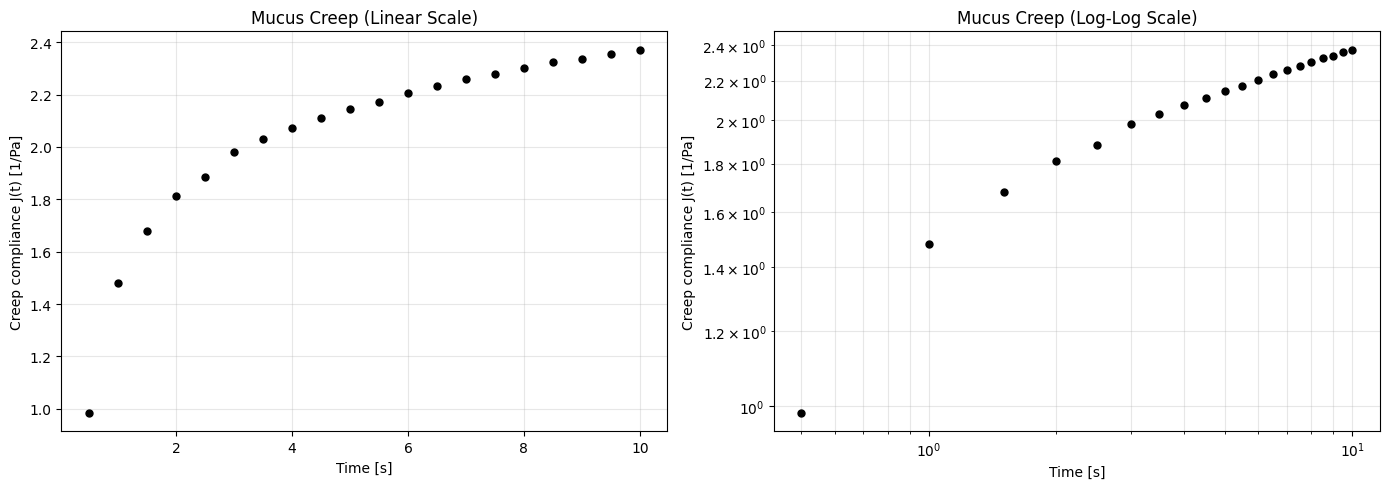

In [4]:
# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1.plot(time_data, J_data, "ko", markersize=5)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Creep compliance J(t) [1/Pa]")
ax1.set_title("Mucus Creep (Linear Scale)")
ax1.grid(True, alpha=0.3)

# Log-log scale
ax2.loglog(time_data, J_data, "ko", markersize=5)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Creep compliance J(t) [1/Pa]")
ax2.set_title("Mucus Creep (Log-Log Scale)")
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

We fit the Giesekus model to the creep compliance data.

In [5]:
# Create and fit Giesekus model
model = GiesekusSingleMode()

# For creep, we need to specify the applied stress
# Assume σ = 1 Pa for compliance normalization (J = γ/σ)
sigma_applied = 1.0  # Pa

# Estimate initial parameters from data to ensure stable fitting
# G ~ 1/J(0), η ~ 1/slope(J) at long times, λ ~ η/G
G_est = 1.0 / J_data[0]
idx_late = len(time_data) // 2
slope = np.polyfit(time_data[idx_late:], J_data[idx_late:], 1)[0]
eta_est = 1.0 / max(slope, 1e-10)
lambda_est = eta_est / max(G_est, 1e-10)

# Set initial parameters
# CRITICAL: eta_s must be non-zero for creep ODE stability
model.parameters.set_value('eta_p', max(eta_est, 1.0))
model.parameters.set_value('lambda_1', max(lambda_est, 0.1))
model.parameters.set_value('alpha', 0.1)
model.parameters.set_value('eta_s', max(0.1, 0.01 * eta_est))  # Small but non-zero

print("Initial parameter estimates from data:")
print(f"  G_est = {G_est:.4g} Pa, η_est = {eta_est:.4g} Pa·s, λ_est = {lambda_est:.4g} s")

t0 = time.time()
model.fit(time_data, J_data, test_mode="creep", sigma_applied=sigma_applied, method='scipy')
t_nlsq = time.time() - t0

print(f"\nNLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
param_names = ["eta_p", "lambda_1", "alpha", "eta_s"]
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

# Derived quantities
eta_p = model.parameters.get_value("eta_p")
eta_s = model.parameters.get_value("eta_s")
lambda_1 = model.parameters.get_value("lambda_1")
alpha = model.parameters.get_value("alpha")

eta_0 = eta_p + eta_s
G_0 = eta_p / lambda_1

print(f"\nDerived quantities:")
print(f"  η₀ = η_p + η_s = {eta_0:.2f} Pa·s")
print(f"  G₀ = η_p/λ = {G_0:.2f} Pa")
print(f"  J₀ = 1/G₀ = {1/G_0:.4e} 1/Pa")

Initial parameter estimates from data:
  G_est = 1.016 Pa, η_est = 23.11 Pa·s, λ_est = 22.73 s



NLSQ fit time: 20.52 s

Fitted parameters:
  eta_p      = 14.32
  lambda_1   = 26.21
  alpha      = 5.723e-10
  eta_s      = 0.1779

Derived quantities:
  η₀ = η_p + η_s = 14.50 Pa·s
  G₀ = η_p/λ = 0.55 Pa
  J₀ = 1/G₀ = 1.8304e+00 1/Pa


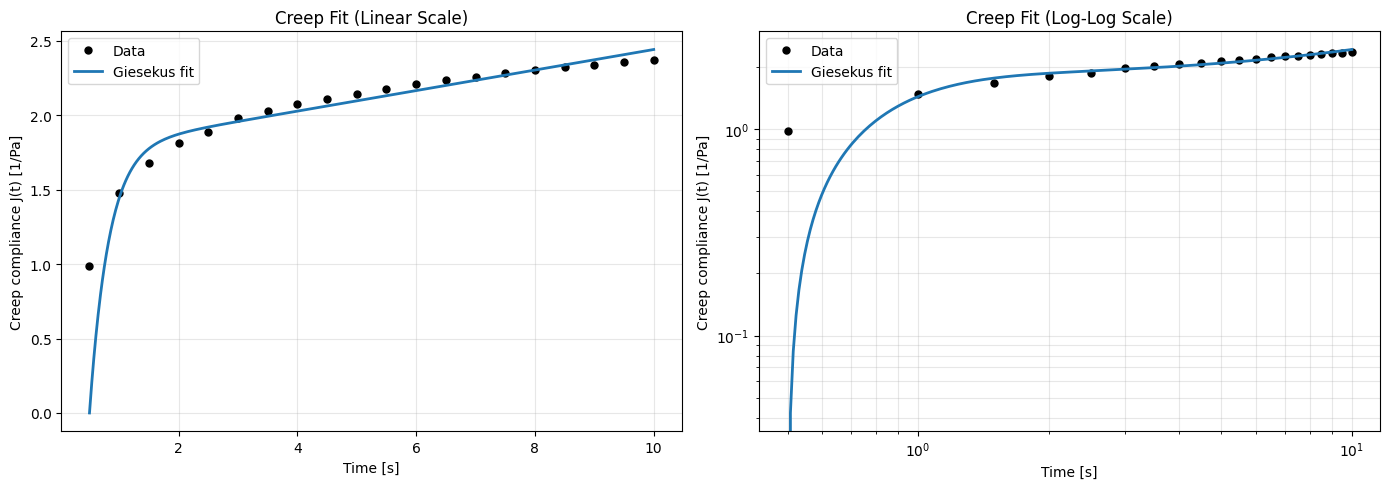

In [6]:
# Plot fit with data
time_fine = np.logspace(
    np.log10(time_data.min()),
    np.log10(time_data.max()),
    200,
)
J_pred = model.predict(time_fine, test_mode="creep", sigma_applied=sigma_applied)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1.plot(time_data, J_data, "ko", markersize=5, label="Data")
ax1.plot(time_fine, J_pred, "-", lw=2, color="C0", label="Giesekus fit")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Creep compliance J(t) [1/Pa]")
ax1.set_title("Creep Fit (Linear Scale)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log-log scale
ax2.loglog(time_data, J_data, "ko", markersize=5, label="Data")
ax2.loglog(time_fine, J_pred, "-", lw=2, color="C0", label="Giesekus fit")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Creep compliance J(t) [1/Pa]")
ax2.set_title("Creep Fit (Log-Log Scale)")
ax2.legend()
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference

In [7]:
# Bayesian inference with NLSQ warm-start
initial_values = {
    name: model.parameters.get_value(name)
    for name in param_names
}
print("Warm-start values:")
for k, v in initial_values.items():
    print(f"  {k}: {v:.4g}")

# Fast demo config
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model.fit_bayesian(
    time_data,
    J_data,
    test_mode="creep",
    sigma_applied=sigma_applied,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values:
  eta_p: 14.32
  lambda_1: 26.21
  alpha: 5.723e-10
  eta_s: 0.1779


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:04<52:10,  4.48s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   0%|          | 2/700 [00:06<32:59,  2.84s/it, 1 steps of size 9.40e-02. acc. prob=0.00]

warmup:   0%|          | 3/700 [00:07<26:53,  2.32s/it, 1 steps of size 3.66e-03. acc. prob=0.00]

warmup:   1%|          | 4/700 [00:09<23:44,  2.05s/it, 1 steps of size 1.22e-04. acc. prob=0.00]

warmup:   1%|          | 5/700 [00:11<21:41,  1.87s/it, 1 steps of size 3.90e-06. acc. prob=0.00]

warmup:   1%|▏         | 9/700 [00:11<07:50,  1.47it/s, 1023 steps of size 3.81e-10. acc. prob=0.15]

warmup:   1%|▏         | 10/700 [00:11<07:11,  1.60it/s, 1023 steps of size 3.80e-10. acc. prob=0.23]

warmup:   2%|▏         | 11/700 [00:12<06:37,  1.73it/s, 1023 steps of size 4.03e-10. acc. prob=0.30]

warmup:   2%|▏         | 12/700 [00:12<06:03,  1.89it/s, 1023 steps of size 4.47e-10. acc. prob=0.36]

warmup:   2%|▏         | 13/700 [00:13<05:39,  2.02it/s, 1023 steps of size 5.13e-10. acc. prob=0.41]

warmup:   2%|▏         | 14/700 [00:13<05:12,  2.19it/s, 1023 steps of size 6.03e-10. acc. prob=0.45]

warmup:   2%|▏         | 15/700 [00:13<05:12,  2.19it/s, 1023 steps of size 7.21e-10. acc. prob=0.49]

warmup:   2%|▏         | 16/700 [00:14<05:09,  2.21it/s, 1023 steps of size 8.74e-10. acc. prob=0.52]

warmup:   2%|▏         | 17/700 [00:14<04:59,  2.28it/s, 1023 steps of size 1.07e-09. acc. prob=0.55]

warmup:   3%|▎         | 18/700 [00:15<04:51,  2.34it/s, 1023 steps of size 1.32e-09. acc. prob=0.57]

warmup:   3%|▎         | 19/700 [00:15<04:55,  2.30it/s, 1023 steps of size 1.63e-09. acc. prob=0.60]

warmup:   3%|▎         | 20/700 [00:15<04:44,  2.39it/s, 1023 steps of size 2.02e-09. acc. prob=0.62]

warmup:   3%|▎         | 21/700 [00:16<04:49,  2.34it/s, 1023 steps of size 2.51e-09. acc. prob=0.63]

warmup:   3%|▎         | 22/700 [00:16<04:58,  2.27it/s, 1023 steps of size 3.11e-09. acc. prob=0.65]

warmup:   3%|▎         | 23/700 [00:17<04:58,  2.27it/s, 1023 steps of size 3.86e-09. acc. prob=0.67]

warmup:   3%|▎         | 24/700 [00:17<04:42,  2.40it/s, 1023 steps of size 4.78e-09. acc. prob=0.68]

warmup:   4%|▎         | 25/700 [00:18<05:03,  2.22it/s, 1023 steps of size 5.91e-09. acc. prob=0.69]

warmup:   4%|▎         | 26/700 [00:18<04:53,  2.30it/s, 1023 steps of size 7.29e-09. acc. prob=0.70]

warmup:   4%|▍         | 27/700 [00:19<04:57,  2.26it/s, 1023 steps of size 8.96e-09. acc. prob=0.72]

warmup:   4%|▍         | 28/700 [00:19<04:43,  2.37it/s, 1023 steps of size 1.10e-08. acc. prob=0.73]

warmup:   4%|▍         | 29/700 [00:19<04:37,  2.42it/s, 1023 steps of size 1.34e-08. acc. prob=0.73]

warmup:   4%|▍         | 30/700 [00:20<04:38,  2.41it/s, 1023 steps of size 1.64e-08. acc. prob=0.74]

warmup:   4%|▍         | 31/700 [00:20<04:29,  2.48it/s, 1023 steps of size 1.99e-08. acc. prob=0.75]

warmup:   5%|▍         | 32/700 [00:21<04:37,  2.41it/s, 1023 steps of size 2.41e-08. acc. prob=0.76]

warmup:   5%|▍         | 33/700 [00:21<04:40,  2.38it/s, 1023 steps of size 2.90e-08. acc. prob=0.77]

warmup:   5%|▍         | 34/700 [00:21<04:38,  2.40it/s, 1023 steps of size 3.49e-08. acc. prob=0.77]

warmup:   5%|▌         | 35/700 [00:22<04:24,  2.51it/s, 1023 steps of size 4.18e-08. acc. prob=0.78]

warmup:   5%|▌         | 36/700 [00:22<04:18,  2.57it/s, 1023 steps of size 5.00e-08. acc. prob=0.79]

warmup:   5%|▌         | 37/700 [00:23<04:37,  2.39it/s, 1023 steps of size 5.95e-08. acc. prob=0.79]

warmup:   5%|▌         | 38/700 [00:23<04:27,  2.47it/s, 1023 steps of size 7.06e-08. acc. prob=0.80]

warmup:   6%|▌         | 39/700 [00:23<04:28,  2.46it/s, 1023 steps of size 8.36e-08. acc. prob=0.80]

warmup:   6%|▌         | 40/700 [00:24<04:16,  2.57it/s, 1023 steps of size 9.86e-08. acc. prob=0.81]

warmup:   6%|▌         | 41/700 [00:24<04:18,  2.55it/s, 1023 steps of size 1.16e-07. acc. prob=0.81]

warmup:   6%|▌         | 42/700 [00:24<04:14,  2.58it/s, 1023 steps of size 1.36e-07. acc. prob=0.82]

warmup:   6%|▌         | 43/700 [00:25<04:24,  2.48it/s, 1023 steps of size 1.59e-07. acc. prob=0.82]

warmup:   6%|▋         | 44/700 [00:25<04:15,  2.56it/s, 1023 steps of size 1.85e-07. acc. prob=0.83]

warmup:   6%|▋         | 45/700 [00:26<04:13,  2.59it/s, 1023 steps of size 2.15e-07. acc. prob=0.83]

warmup:   7%|▋         | 46/700 [00:26<04:32,  2.40it/s, 1023 steps of size 2.50e-07. acc. prob=0.83]

warmup:   7%|▋         | 47/700 [00:27<04:26,  2.45it/s, 1023 steps of size 2.89e-07. acc. prob=0.84]

warmup:   7%|▋         | 48/700 [00:27<04:43,  2.30it/s, 1023 steps of size 3.33e-07. acc. prob=0.84]

warmup:   7%|▋         | 49/700 [00:27<04:30,  2.40it/s, 1023 steps of size 3.83e-07. acc. prob=0.84]

warmup:   7%|▋         | 50/700 [00:28<04:39,  2.32it/s, 1023 steps of size 4.39e-07. acc. prob=0.85]

warmup:   7%|▋         | 51/700 [00:28<04:29,  2.41it/s, 1023 steps of size 5.03e-07. acc. prob=0.85]

warmup:   7%|▋         | 52/700 [00:29<04:30,  2.40it/s, 1023 steps of size 5.75e-07. acc. prob=0.85]

warmup:   8%|▊         | 53/700 [00:29<04:16,  2.52it/s, 1023 steps of size 6.55e-07. acc. prob=0.85]

warmup:   8%|▊         | 54/700 [00:29<04:16,  2.52it/s, 1023 steps of size 7.45e-07. acc. prob=0.86]

warmup:   8%|▊         | 55/700 [00:30<04:10,  2.57it/s, 1023 steps of size 8.45e-07. acc. prob=0.86]

warmup:   8%|▊         | 56/700 [00:30<04:06,  2.61it/s, 1023 steps of size 9.57e-07. acc. prob=0.86]

warmup:   8%|▊         | 57/700 [00:31<04:07,  2.59it/s, 1023 steps of size 1.08e-06. acc. prob=0.87]

warmup:   8%|▊         | 58/700 [00:31<04:12,  2.55it/s, 1023 steps of size 1.22e-06. acc. prob=0.87]

warmup:   8%|▊         | 59/700 [00:31<04:22,  2.44it/s, 1023 steps of size 1.37e-06. acc. prob=0.87]

warmup:   9%|▊         | 60/700 [00:32<04:14,  2.51it/s, 1023 steps of size 1.54e-06. acc. prob=0.87]

warmup:   9%|▊         | 61/700 [00:32<04:39,  2.29it/s, 1023 steps of size 1.73e-06. acc. prob=0.87]

warmup:   9%|▉         | 62/700 [00:33<04:22,  2.43it/s, 1023 steps of size 1.94e-06. acc. prob=0.88]

warmup:   9%|▉         | 63/700 [00:33<04:43,  2.25it/s, 1023 steps of size 2.16e-06. acc. prob=0.88]

warmup:   9%|▉         | 64/700 [00:34<04:27,  2.38it/s, 1023 steps of size 2.41e-06. acc. prob=0.88]

warmup:   9%|▉         | 65/700 [00:34<04:55,  2.15it/s, 1023 steps of size 2.69e-06. acc. prob=0.88]

warmup:   9%|▉         | 66/700 [00:34<04:35,  2.30it/s, 1023 steps of size 2.99e-06. acc. prob=0.88]

warmup:  10%|▉         | 67/700 [00:35<05:03,  2.09it/s, 1023 steps of size 3.32e-06. acc. prob=0.89]

warmup:  10%|▉         | 68/700 [00:35<04:52,  2.16it/s, 1023 steps of size 3.68e-06. acc. prob=0.89]

warmup:  10%|▉         | 69/700 [00:36<05:04,  2.07it/s, 1023 steps of size 4.07e-06. acc. prob=0.89]

warmup:  10%|█         | 70/700 [00:36<04:43,  2.22it/s, 1023 steps of size 4.50e-06. acc. prob=0.89]

warmup:  10%|█         | 71/700 [00:37<04:59,  2.10it/s, 1023 steps of size 4.96e-06. acc. prob=0.89]

warmup:  10%|█         | 72/700 [00:37<05:05,  2.05it/s, 1023 steps of size 5.47e-06. acc. prob=0.89]

warmup:  10%|█         | 73/700 [00:38<05:03,  2.07it/s, 1023 steps of size 6.02e-06. acc. prob=0.89]

warmup:  11%|█         | 74/700 [00:38<04:44,  2.20it/s, 1023 steps of size 6.61e-06. acc. prob=0.90]

warmup:  11%|█         | 75/700 [00:39<04:36,  2.26it/s, 1023 steps of size 7.26e-06. acc. prob=0.90]

warmup:  11%|█         | 76/700 [00:39<04:20,  2.40it/s, 1023 steps of size 7.96e-06. acc. prob=0.90]

warmup:  11%|█         | 77/700 [00:39<04:18,  2.41it/s, 1023 steps of size 8.71e-06. acc. prob=0.90]

warmup:  11%|█         | 78/700 [00:40<04:14,  2.44it/s, 1023 steps of size 9.52e-06. acc. prob=0.90]

warmup:  11%|█▏        | 79/700 [00:40<04:33,  2.27it/s, 1023 steps of size 1.04e-05. acc. prob=0.90]

warmup:  11%|█▏        | 80/700 [00:41<04:23,  2.36it/s, 1023 steps of size 1.13e-05. acc. prob=0.90]

warmup:  12%|█▏        | 81/700 [00:41<04:26,  2.32it/s, 1023 steps of size 1.24e-05. acc. prob=0.91]

warmup:  12%|█▏        | 82/700 [00:42<04:15,  2.42it/s, 1023 steps of size 1.35e-05. acc. prob=0.91]

warmup:  12%|█▏        | 83/700 [00:42<04:11,  2.45it/s, 1023 steps of size 1.46e-05. acc. prob=0.91]

warmup:  12%|█▏        | 84/700 [00:42<04:06,  2.50it/s, 1023 steps of size 1.59e-05. acc. prob=0.91]

warmup:  12%|█▏        | 85/700 [00:43<03:56,  2.60it/s, 1023 steps of size 1.72e-05. acc. prob=0.91]

warmup:  12%|█▏        | 86/700 [00:43<03:32,  2.90it/s, 511 steps of size 1.87e-05. acc. prob=0.91] 

warmup:  12%|█▏        | 87/700 [00:43<03:40,  2.78it/s, 1023 steps of size 2.02e-05. acc. prob=0.91]

warmup:  13%|█▎        | 88/700 [00:44<03:45,  2.71it/s, 1023 steps of size 2.19e-05. acc. prob=0.91]

warmup:  13%|█▎        | 89/700 [00:44<03:51,  2.63it/s, 1023 steps of size 2.37e-05. acc. prob=0.91]

warmup:  13%|█▎        | 91/700 [00:44<02:44,  3.70it/s, 511 steps of size 2.75e-05. acc. prob=0.92] 

warmup:  13%|█▎        | 92/700 [00:45<03:10,  3.19it/s, 1023 steps of size 2.97e-05. acc. prob=0.92]

warmup:  13%|█▎        | 93/700 [00:45<03:25,  2.96it/s, 1023 steps of size 3.20e-05. acc. prob=0.92]

warmup:  13%|█▎        | 94/700 [00:46<04:37,  2.18it/s, 1023 steps of size 3.44e-05. acc. prob=0.92]

warmup:  14%|█▎        | 95/700 [00:46<04:04,  2.48it/s, 511 steps of size 3.70e-05. acc. prob=0.92] 

warmup:  14%|█▎        | 96/700 [00:47<03:32,  2.84it/s, 511 steps of size 3.97e-05. acc. prob=0.92]

warmup:  14%|█▍        | 97/700 [00:47<03:54,  2.57it/s, 1023 steps of size 4.26e-05. acc. prob=0.92]

warmup:  14%|█▍        | 98/700 [00:47<03:19,  3.02it/s, 511 steps of size 4.57e-05. acc. prob=0.92] 

warmup:  14%|█▍        | 99/700 [00:47<02:52,  3.48it/s, 511 steps of size 4.90e-05. acc. prob=0.92]

warmup:  14%|█▍        | 100/700 [00:48<03:36,  2.77it/s, 1023 steps of size 5.24e-05. acc. prob=0.92]

warmup:  14%|█▍        | 101/700 [00:48<03:34,  2.79it/s, 1023 steps of size 5.34e-04. acc. prob=0.92]

warmup:  15%|█▍        | 102/700 [00:49<04:04,  2.45it/s, 1023 steps of size 5.50e-04. acc. prob=0.92]

warmup:  15%|█▍        | 103/700 [00:49<03:24,  2.91it/s, 511 steps of size 5.68e-04. acc. prob=0.93] 

warmup:  15%|█▍        | 104/700 [00:49<03:31,  2.82it/s, 1023 steps of size 5.88e-04. acc. prob=0.93]

warmup:  15%|█▌        | 105/700 [00:50<03:47,  2.62it/s, 1023 steps of size 6.08e-04. acc. prob=0.93]

warmup:  15%|█▌        | 106/700 [00:50<03:43,  2.66it/s, 1023 steps of size 6.30e-04. acc. prob=0.93]

warmup:  15%|█▌        | 107/700 [00:51<04:04,  2.43it/s, 1023 steps of size 6.52e-04. acc. prob=0.93]

warmup:  15%|█▌        | 108/700 [00:51<03:54,  2.52it/s, 1023 steps of size 6.74e-04. acc. prob=0.93]

warmup:  16%|█▌        | 109/700 [00:52<04:07,  2.39it/s, 1023 steps of size 6.97e-04. acc. prob=0.93]

warmup:  16%|█▌        | 110/700 [00:52<03:58,  2.47it/s, 1023 steps of size 7.19e-04. acc. prob=0.93]

warmup:  16%|█▌        | 111/700 [00:52<03:51,  2.54it/s, 1023 steps of size 7.42e-04. acc. prob=0.93]

warmup:  16%|█▌        | 112/700 [00:53<04:05,  2.39it/s, 1023 steps of size 7.65e-04. acc. prob=0.93]

warmup:  16%|█▌        | 113/700 [00:53<03:55,  2.49it/s, 1023 steps of size 7.88e-04. acc. prob=0.93]

warmup:  16%|█▋        | 114/700 [00:54<03:56,  2.48it/s, 1023 steps of size 8.11e-04. acc. prob=0.93]

warmup:  16%|█▋        | 115/700 [00:54<03:48,  2.56it/s, 1023 steps of size 8.34e-04. acc. prob=0.93]

warmup:  17%|█▋        | 116/700 [00:54<03:56,  2.47it/s, 1023 steps of size 8.58e-04. acc. prob=0.93]

warmup:  17%|█▋        | 117/700 [00:55<03:53,  2.49it/s, 1023 steps of size 8.81e-04. acc. prob=0.93]

warmup:  17%|█▋        | 118/700 [00:55<03:55,  2.47it/s, 1023 steps of size 9.04e-04. acc. prob=0.93]

warmup:  17%|█▋        | 119/700 [00:55<03:47,  2.55it/s, 1023 steps of size 9.28e-04. acc. prob=0.94]

warmup:  17%|█▋        | 120/700 [00:56<04:00,  2.41it/s, 1023 steps of size 9.52e-04. acc. prob=0.94]

warmup:  17%|█▋        | 121/700 [00:56<03:59,  2.42it/s, 1023 steps of size 9.75e-04. acc. prob=0.94]

warmup:  17%|█▋        | 122/700 [00:57<04:03,  2.37it/s, 1023 steps of size 9.99e-04. acc. prob=0.94]

warmup:  18%|█▊        | 123/700 [00:57<03:58,  2.42it/s, 1023 steps of size 1.02e-03. acc. prob=0.94]

warmup:  18%|█▊        | 124/700 [00:58<04:22,  2.20it/s, 1023 steps of size 1.05e-03. acc. prob=0.94]

warmup:  18%|█▊        | 125/700 [00:58<04:24,  2.18it/s, 1023 steps of size 1.07e-03. acc. prob=0.94]

warmup:  18%|█▊        | 126/700 [00:59<04:09,  2.30it/s, 1023 steps of size 1.09e-03. acc. prob=0.94]

warmup:  18%|█▊        | 127/700 [00:59<04:15,  2.24it/s, 1023 steps of size 1.12e-03. acc. prob=0.94]

warmup:  18%|█▊        | 128/700 [01:00<04:19,  2.21it/s, 1023 steps of size 1.14e-03. acc. prob=0.94]

warmup:  18%|█▊        | 129/700 [01:00<04:21,  2.19it/s, 1023 steps of size 1.17e-03. acc. prob=0.94]

warmup:  19%|█▊        | 130/700 [01:00<04:12,  2.26it/s, 1023 steps of size 1.19e-03. acc. prob=0.94]

warmup:  19%|█▊        | 131/700 [01:01<04:23,  2.16it/s, 1023 steps of size 1.22e-03. acc. prob=0.94]

warmup:  19%|█▉        | 132/700 [01:01<04:08,  2.28it/s, 1023 steps of size 1.24e-03. acc. prob=0.94]

warmup:  19%|█▉        | 133/700 [01:02<04:05,  2.31it/s, 1023 steps of size 1.27e-03. acc. prob=0.94]

warmup:  19%|█▉        | 134/700 [01:02<03:50,  2.45it/s, 1023 steps of size 1.29e-03. acc. prob=0.94]

warmup:  19%|█▉        | 135/700 [01:03<04:01,  2.34it/s, 1023 steps of size 1.32e-03. acc. prob=0.94]

warmup:  19%|█▉        | 136/700 [01:03<04:01,  2.33it/s, 1023 steps of size 1.34e-03. acc. prob=0.94]

warmup:  20%|█▉        | 137/700 [01:03<03:56,  2.38it/s, 1023 steps of size 1.37e-03. acc. prob=0.94]

warmup:  20%|█▉        | 138/700 [01:04<03:52,  2.42it/s, 1023 steps of size 1.39e-03. acc. prob=0.94]

warmup:  20%|█▉        | 139/700 [01:04<03:45,  2.49it/s, 1023 steps of size 1.42e-03. acc. prob=0.94]

warmup:  20%|██        | 140/700 [01:05<04:00,  2.33it/s, 1023 steps of size 1.44e-03. acc. prob=0.95]

warmup:  20%|██        | 141/700 [01:05<04:03,  2.29it/s, 1023 steps of size 1.47e-03. acc. prob=0.95]

warmup:  20%|██        | 142/700 [01:06<04:13,  2.20it/s, 1023 steps of size 1.49e-03. acc. prob=0.95]

warmup:  20%|██        | 143/700 [01:06<04:07,  2.25it/s, 1023 steps of size 1.52e-03. acc. prob=0.95]

warmup:  21%|██        | 144/700 [01:06<03:55,  2.36it/s, 1023 steps of size 1.55e-03. acc. prob=0.95]

warmup:  21%|██        | 145/700 [01:07<03:58,  2.33it/s, 1023 steps of size 1.57e-03. acc. prob=0.95]

warmup:  21%|██        | 146/700 [01:07<04:11,  2.20it/s, 1023 steps of size 1.60e-03. acc. prob=0.95]

warmup:  21%|██        | 147/700 [01:08<03:55,  2.35it/s, 1023 steps of size 1.62e-03. acc. prob=0.95]

warmup:  21%|██        | 148/700 [01:08<03:59,  2.31it/s, 1023 steps of size 1.65e-03. acc. prob=0.95]

warmup:  21%|██▏       | 149/700 [01:09<03:58,  2.31it/s, 1023 steps of size 1.68e-03. acc. prob=0.95]

warmup:  21%|██▏       | 150/700 [01:09<04:21,  2.10it/s, 1023 steps of size 1.70e-03. acc. prob=0.95]

warmup:  22%|██▏       | 151/700 [01:10<04:04,  2.25it/s, 1023 steps of size 1.73e-02. acc. prob=0.95]

warmup:  22%|██▏       | 153/700 [01:10<02:31,  3.61it/s, 127 steps of size 1.84e-02. acc. prob=0.95] 

warmup:  22%|██▏       | 154/700 [01:10<02:42,  3.36it/s, 1023 steps of size 1.91e-02. acc. prob=0.95]

warmup:  22%|██▏       | 156/700 [01:10<01:58,  4.59it/s, 511 steps of size 2.04e-02. acc. prob=0.95] 

warmup:  22%|██▏       | 157/700 [01:11<02:18,  3.93it/s, 1023 steps of size 2.11e-02. acc. prob=0.95]

warmup:  23%|██▎       | 158/700 [01:11<02:31,  3.59it/s, 1023 steps of size 2.19e-02. acc. prob=0.95]

warmup:  23%|██▎       | 159/700 [01:11<02:54,  3.09it/s, 1023 steps of size 2.26e-02. acc. prob=0.95]

warmup:  23%|██▎       | 160/700 [01:12<02:52,  3.14it/s, 1023 steps of size 2.33e-02. acc. prob=0.95]

warmup:  23%|██▎       | 161/700 [01:12<02:25,  3.70it/s, 511 steps of size 2.41e-02. acc. prob=0.95] 

warmup:  23%|██▎       | 162/700 [01:12<02:28,  3.62it/s, 1023 steps of size 2.48e-02. acc. prob=0.95]

warmup:  23%|██▎       | 164/700 [01:13<01:59,  4.50it/s, 1023 steps of size 2.63e-02. acc. prob=0.95]

warmup:  24%|██▎       | 165/700 [01:13<02:15,  3.94it/s, 1023 steps of size 2.70e-02. acc. prob=0.95]

warmup:  24%|██▎       | 166/700 [01:13<02:22,  3.73it/s, 1023 steps of size 2.78e-02. acc. prob=0.95]

warmup:  24%|██▍       | 167/700 [01:14<02:29,  3.56it/s, 1023 steps of size 2.85e-02. acc. prob=0.95]

warmup:  24%|██▍       | 168/700 [01:14<02:41,  3.29it/s, 1023 steps of size 2.93e-02. acc. prob=0.95]

warmup:  24%|██▍       | 169/700 [01:14<02:27,  3.61it/s, 703 steps of size 3.00e-02. acc. prob=0.95] 

warmup:  24%|██▍       | 170/700 [01:14<02:44,  3.23it/s, 1023 steps of size 3.07e-02. acc. prob=0.95]

warmup:  25%|██▍       | 172/700 [01:15<02:00,  4.39it/s, 767 steps of size 3.22e-02. acc. prob=0.96] 

warmup:  25%|██▍       | 173/700 [01:15<02:22,  3.71it/s, 1023 steps of size 3.29e-02. acc. prob=0.96]

warmup:  25%|██▌       | 175/700 [01:16<02:07,  4.13it/s, 1023 steps of size 3.44e-02. acc. prob=0.96]

warmup:  25%|██▌       | 177/700 [01:16<01:56,  4.50it/s, 1023 steps of size 3.60e-02. acc. prob=0.96]

warmup:  25%|██▌       | 178/700 [01:16<02:10,  3.99it/s, 1023 steps of size 3.68e-02. acc. prob=0.96]

warmup:  26%|██▌       | 179/700 [01:17<02:22,  3.65it/s, 1023 steps of size 3.75e-02. acc. prob=0.96]

warmup:  26%|██▌       | 180/700 [01:17<02:41,  3.21it/s, 1023 steps of size 3.83e-02. acc. prob=0.96]

warmup:  26%|██▌       | 181/700 [01:17<02:30,  3.45it/s, 639 steps of size 3.91e-02. acc. prob=0.96] 

warmup:  26%|██▌       | 182/700 [01:18<02:39,  3.26it/s, 1023 steps of size 3.99e-02. acc. prob=0.96]

warmup:  26%|██▌       | 183/700 [01:19<04:02,  2.14it/s, 1023 steps of size 4.06e-02. acc. prob=0.96]

warmup:  26%|██▋       | 184/700 [01:19<04:18,  2.00it/s, 1023 steps of size 4.14e-02. acc. prob=0.96]

warmup:  26%|██▋       | 185/700 [01:19<03:50,  2.23it/s, 1023 steps of size 4.22e-02. acc. prob=0.96]

warmup:  27%|██▋       | 187/700 [01:20<02:17,  3.73it/s, 319 steps of size 4.37e-02. acc. prob=0.96] 

warmup:  27%|██▋       | 189/700 [01:20<01:42,  5.00it/s, 255 steps of size 4.51e-02. acc. prob=0.96]

warmup:  27%|██▋       | 191/700 [01:20<01:39,  5.13it/s, 1023 steps of size 4.68e-02. acc. prob=0.96]

warmup:  28%|██▊       | 194/700 [01:20<01:10,  7.16it/s, 511 steps of size 4.92e-02. acc. prob=0.96] 

warmup:  28%|██▊       | 195/700 [01:20<01:16,  6.59it/s, 511 steps of size 4.99e-02. acc. prob=0.96]

warmup:  28%|██▊       | 196/700 [01:21<01:28,  5.69it/s, 895 steps of size 5.08e-02. acc. prob=0.96]

warmup:  28%|██▊       | 197/700 [01:21<01:25,  5.85it/s, 511 steps of size 5.16e-02. acc. prob=0.96]

warmup:  28%|██▊       | 198/700 [01:21<01:25,  5.86it/s, 511 steps of size 5.24e-02. acc. prob=0.96]

sample:  29%|██▊       | 201/700 [01:22<01:18,  6.35it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  29%|██▉       | 203/700 [01:22<01:08,  7.29it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  29%|██▉       | 204/700 [01:22<01:07,  7.31it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  29%|██▉       | 205/700 [01:22<01:33,  5.30it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  29%|██▉       | 206/700 [01:23<01:46,  4.65it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  30%|██▉       | 208/700 [01:23<01:14,  6.57it/s, 127 steps of size 4.23e-02. acc. prob=1.00] 

sample:  30%|██▉       | 209/700 [01:23<01:16,  6.41it/s, 319 steps of size 4.23e-02. acc. prob=1.00]

sample:  30%|███       | 210/700 [01:23<01:20,  6.11it/s, 639 steps of size 4.23e-02. acc. prob=1.00]

sample:  30%|███       | 211/700 [01:23<01:29,  5.47it/s, 767 steps of size 4.23e-02. acc. prob=1.00]

sample:  30%|███       | 213/700 [01:24<01:24,  5.77it/s, 895 steps of size 4.23e-02. acc. prob=1.00]

sample:  31%|███       | 214/700 [01:24<01:42,  4.76it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  31%|███       | 215/700 [01:24<01:58,  4.08it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  31%|███       | 216/700 [01:25<02:14,  3.61it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  31%|███       | 218/700 [01:25<01:35,  5.07it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  31%|███▏      | 220/700 [01:25<01:19,  6.01it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  32%|███▏      | 221/700 [01:25<01:38,  4.85it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  32%|███▏      | 222/700 [01:25<01:27,  5.44it/s, 383 steps of size 4.23e-02. acc. prob=1.00] 

sample:  32%|███▏      | 224/700 [01:26<01:26,  5.53it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  32%|███▏      | 226/700 [01:26<01:09,  6.82it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  32%|███▏      | 227/700 [01:26<01:07,  7.04it/s, 319 steps of size 4.23e-02. acc. prob=1.00]

sample:  33%|███▎      | 229/700 [01:26<00:52,  8.98it/s, 127 steps of size 4.23e-02. acc. prob=1.00]

sample:  33%|███▎      | 231/700 [01:27<01:06,  7.01it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  33%|███▎      | 233/700 [01:27<01:18,  5.98it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  33%|███▎      | 234/700 [01:27<01:12,  6.40it/s, 255 steps of size 4.23e-02. acc. prob=1.00] 

sample:  34%|███▎      | 235/700 [01:28<01:29,  5.21it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  34%|███▍      | 237/700 [01:28<01:16,  6.03it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  34%|███▍      | 239/700 [01:28<01:00,  7.58it/s, 255 steps of size 4.23e-02. acc. prob=1.00]

sample:  34%|███▍      | 241/700 [01:28<01:00,  7.64it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  35%|███▍      | 243/700 [01:28<00:53,  8.57it/s, 479 steps of size 4.23e-02. acc. prob=1.00]

sample:  35%|███▌      | 245/700 [01:29<00:52,  8.60it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  35%|███▌      | 247/700 [01:29<00:50,  9.04it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  36%|███▌      | 249/700 [01:29<00:42, 10.56it/s, 127 steps of size 4.23e-02. acc. prob=1.00]

sample:  36%|███▌      | 251/700 [01:30<01:15,  5.91it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  36%|███▌      | 252/700 [01:30<01:31,  4.92it/s, 703 steps of size 4.23e-02. acc. prob=1.00] 

sample:  36%|███▌      | 253/700 [01:30<01:34,  4.71it/s, 767 steps of size 4.23e-02. acc. prob=1.00]

sample:  36%|███▋      | 255/700 [01:31<01:32,  4.81it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  37%|███▋      | 256/700 [01:31<01:45,  4.21it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  37%|███▋      | 258/700 [01:31<01:40,  4.42it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  37%|███▋      | 259/700 [01:31<01:34,  4.68it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  37%|███▋      | 260/700 [01:32<01:29,  4.89it/s, 319 steps of size 4.23e-02. acc. prob=1.00]

sample:  37%|███▋      | 261/700 [01:32<01:24,  5.20it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  37%|███▋      | 262/700 [01:32<01:44,  4.20it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  38%|███▊      | 263/700 [01:33<02:03,  3.54it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  38%|███▊      | 265/700 [01:33<01:44,  4.17it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  38%|███▊      | 266/700 [01:33<02:06,  3.44it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  38%|███▊      | 268/700 [01:34<02:00,  3.57it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  38%|███▊      | 269/700 [01:34<02:11,  3.28it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  39%|███▊      | 270/700 [01:35<02:02,  3.51it/s, 639 steps of size 4.23e-02. acc. prob=1.00] 

sample:  39%|███▊      | 271/700 [01:35<02:09,  3.31it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  39%|███▉      | 272/700 [01:35<01:52,  3.81it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  39%|███▉      | 273/700 [01:35<02:07,  3.35it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  39%|███▉      | 274/700 [01:36<02:15,  3.14it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  39%|███▉      | 276/700 [01:36<01:58,  3.57it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  40%|███▉      | 277/700 [01:37<02:02,  3.44it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  40%|███▉      | 279/700 [01:37<01:49,  3.85it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  40%|████      | 280/700 [01:37<01:54,  3.67it/s, 639 steps of size 4.23e-02. acc. prob=1.00] 

sample:  40%|████      | 281/700 [01:38<02:00,  3.47it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  40%|████      | 282/700 [01:38<02:07,  3.28it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  40%|████      | 283/700 [01:38<02:06,  3.28it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  41%|████      | 284/700 [01:39<02:08,  3.23it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  41%|████      | 286/700 [01:39<01:46,  3.90it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  41%|████      | 287/700 [01:39<01:50,  3.74it/s, 639 steps of size 4.23e-02. acc. prob=1.00] 

sample:  41%|████▏     | 290/700 [01:40<01:29,  4.58it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  42%|████▏     | 291/700 [01:40<01:23,  4.88it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  42%|████▏     | 294/700 [01:40<01:01,  6.60it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  42%|████▏     | 295/700 [01:41<01:06,  6.05it/s, 639 steps of size 4.23e-02. acc. prob=1.00]

sample:  42%|████▏     | 297/700 [01:41<01:26,  4.68it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  43%|████▎     | 298/700 [01:42<01:48,  3.71it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  43%|████▎     | 299/700 [01:42<01:36,  4.15it/s, 383 steps of size 4.23e-02. acc. prob=1.00] 

sample:  43%|████▎     | 300/700 [01:42<01:31,  4.39it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  43%|████▎     | 302/700 [01:42<01:25,  4.66it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  43%|████▎     | 303/700 [01:43<01:21,  4.89it/s, 447 steps of size 4.23e-02. acc. prob=1.00] 

sample:  43%|████▎     | 304/700 [01:43<01:53,  3.50it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  44%|████▎     | 306/700 [01:43<01:26,  4.53it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  44%|████▍     | 307/700 [01:43<01:21,  4.81it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  44%|████▍     | 309/700 [01:44<01:03,  6.18it/s, 383 steps of size 4.23e-02. acc. prob=1.00]

sample:  44%|████▍     | 310/700 [01:44<01:19,  4.89it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  44%|████▍     | 311/700 [01:44<01:34,  4.13it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  45%|████▍     | 312/700 [01:45<01:43,  3.74it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  45%|████▍     | 313/700 [01:45<01:34,  4.11it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  45%|████▌     | 315/700 [01:45<01:12,  5.29it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  45%|████▌     | 316/700 [01:46<01:34,  4.05it/s, 767 steps of size 4.23e-02. acc. prob=1.00]

sample:  45%|████▌     | 317/700 [01:46<01:36,  3.99it/s, 831 steps of size 4.23e-02. acc. prob=1.00]

sample:  45%|████▌     | 318/700 [01:46<01:50,  3.45it/s, 895 steps of size 4.23e-02. acc. prob=1.00]

sample:  46%|████▌     | 319/700 [01:47<01:57,  3.24it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  46%|████▌     | 321/700 [01:47<01:29,  4.24it/s, 863 steps of size 4.23e-02. acc. prob=1.00] 

sample:  46%|████▌     | 322/700 [01:47<01:27,  4.33it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  46%|████▌     | 323/700 [01:47<01:29,  4.23it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  46%|████▋     | 324/700 [01:48<01:39,  3.77it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  46%|████▋     | 325/700 [01:48<02:07,  2.95it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  47%|████▋     | 326/700 [01:49<02:14,  2.78it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  47%|████▋     | 327/700 [01:49<02:07,  2.92it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  47%|████▋     | 328/700 [01:49<02:07,  2.91it/s, 895 steps of size 4.23e-02. acc. prob=1.00] 

sample:  47%|████▋     | 330/700 [01:50<01:42,  3.59it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  47%|████▋     | 331/700 [01:50<01:30,  4.10it/s, 255 steps of size 4.23e-02. acc. prob=1.00] 

sample:  47%|████▋     | 332/700 [01:50<01:36,  3.80it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  48%|████▊     | 333/700 [01:50<01:26,  4.26it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  48%|████▊     | 335/700 [01:51<01:17,  4.74it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  48%|████▊     | 337/700 [01:51<01:17,  4.69it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  48%|████▊     | 338/700 [01:51<01:25,  4.24it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  48%|████▊     | 339/700 [01:52<01:30,  3.99it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  49%|████▊     | 340/700 [01:52<01:46,  3.40it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  49%|████▊     | 341/700 [01:52<01:47,  3.35it/s, 895 steps of size 4.23e-02. acc. prob=1.00] 

sample:  49%|████▉     | 342/700 [01:53<01:40,  3.57it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  49%|████▉     | 343/700 [01:53<01:43,  3.47it/s, 783 steps of size 4.23e-02. acc. prob=1.00]

sample:  49%|████▉     | 344/700 [01:53<01:58,  3.01it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  49%|████▉     | 346/700 [01:54<01:14,  4.73it/s, 255 steps of size 4.23e-02. acc. prob=1.00] 

sample:  50%|████▉     | 347/700 [01:54<01:10,  5.00it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  50%|█████     | 350/700 [01:54<00:49,  7.06it/s, 383 steps of size 4.23e-02. acc. prob=1.00]

sample:  50%|█████     | 351/700 [01:54<00:50,  6.97it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  50%|█████     | 352/700 [01:54<01:06,  5.23it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  51%|█████     | 354/700 [01:55<00:53,  6.45it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  51%|█████     | 356/700 [01:55<00:55,  6.24it/s, 767 steps of size 4.23e-02. acc. prob=1.00]

sample:  51%|█████     | 357/700 [01:55<01:11,  4.77it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  51%|█████▏    | 359/700 [01:56<01:06,  5.10it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  52%|█████▏    | 361/700 [01:56<01:06,  5.09it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  52%|█████▏    | 362/700 [01:56<01:04,  5.22it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  52%|█████▏    | 363/700 [01:57<01:13,  4.56it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  52%|█████▏    | 364/700 [01:57<01:11,  4.67it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  52%|█████▏    | 365/700 [01:57<01:20,  4.15it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  52%|█████▏    | 366/700 [01:57<01:25,  3.89it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  53%|█████▎    | 369/700 [01:58<00:55,  5.92it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  53%|█████▎    | 371/700 [01:58<01:01,  5.39it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  53%|█████▎    | 372/700 [01:58<01:03,  5.14it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  53%|█████▎    | 373/700 [01:59<00:59,  5.47it/s, 319 steps of size 4.23e-02. acc. prob=1.00]

sample:  53%|█████▎    | 374/700 [01:59<01:15,  4.29it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  54%|█████▎    | 375/700 [01:59<01:26,  3.74it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  54%|█████▎    | 376/700 [02:00<01:42,  3.17it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  54%|█████▍    | 377/700 [02:00<01:44,  3.10it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  54%|█████▍    | 378/700 [02:00<01:46,  3.02it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  54%|█████▍    | 379/700 [02:01<01:50,  2.90it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  54%|█████▍    | 380/700 [02:01<01:33,  3.43it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  54%|█████▍    | 381/700 [02:01<01:45,  3.01it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  55%|█████▍    | 383/700 [02:02<01:06,  4.80it/s, 127 steps of size 4.23e-02. acc. prob=1.00] 

sample:  55%|█████▍    | 384/700 [02:02<01:02,  5.07it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  55%|█████▌    | 385/700 [02:02<01:14,  4.24it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  55%|█████▌    | 387/700 [02:02<00:57,  5.44it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  56%|█████▌    | 389/700 [02:03<00:49,  6.26it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  56%|█████▌    | 390/700 [02:03<00:45,  6.74it/s, 383 steps of size 4.23e-02. acc. prob=1.00]

sample:  56%|█████▌    | 391/700 [02:03<01:03,  4.89it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  56%|█████▌    | 393/700 [02:03<01:00,  5.10it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  56%|█████▋    | 394/700 [02:04<01:22,  3.72it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  56%|█████▋    | 395/700 [02:04<01:30,  3.38it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  57%|█████▋    | 396/700 [02:04<01:20,  3.78it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  57%|█████▋    | 398/700 [02:05<01:20,  3.76it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  57%|█████▋    | 400/700 [02:05<01:13,  4.08it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  57%|█████▋    | 402/700 [02:06<01:01,  4.81it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  58%|█████▊    | 403/700 [02:06<00:56,  5.21it/s, 255 steps of size 4.23e-02. acc. prob=1.00]

sample:  58%|█████▊    | 404/700 [02:06<01:08,  4.31it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  58%|█████▊    | 405/700 [02:07<01:19,  3.70it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  58%|█████▊    | 406/700 [02:07<01:31,  3.21it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  58%|█████▊    | 407/700 [02:07<01:30,  3.23it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  58%|█████▊    | 408/700 [02:08<01:22,  3.54it/s, 639 steps of size 4.23e-02. acc. prob=1.00] 

sample:  58%|█████▊    | 409/700 [02:08<01:11,  4.07it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  59%|█████▉    | 412/700 [02:08<00:39,  7.35it/s, 127 steps of size 4.23e-02. acc. prob=1.00]

sample:  59%|█████▉    | 413/700 [02:08<00:54,  5.31it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  59%|█████▉    | 414/700 [02:09<01:09,  4.12it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  59%|█████▉    | 416/700 [02:09<01:07,  4.23it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  60%|█████▉    | 417/700 [02:09<00:59,  4.75it/s, 255 steps of size 4.23e-02. acc. prob=1.00] 

sample:  60%|█████▉    | 418/700 [02:10<01:14,  3.80it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  60%|█████▉    | 419/700 [02:10<01:10,  3.97it/s, 575 steps of size 4.23e-02. acc. prob=1.00] 

sample:  60%|██████    | 420/700 [02:10<01:04,  4.34it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  60%|██████    | 421/700 [02:10<01:13,  3.82it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  60%|██████    | 423/700 [02:11<01:08,  4.07it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  61%|██████    | 425/700 [02:11<00:49,  5.55it/s, 319 steps of size 4.23e-02. acc. prob=1.00] 

sample:  61%|██████    | 427/700 [02:11<00:52,  5.22it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  61%|██████    | 428/700 [02:12<01:02,  4.33it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  61%|██████▏   | 429/700 [02:12<01:12,  3.75it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  61%|██████▏   | 430/700 [02:13<01:19,  3.39it/s, 895 steps of size 4.23e-02. acc. prob=1.00] 

sample:  62%|██████▏   | 431/700 [02:13<01:23,  3.24it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  62%|██████▏   | 433/700 [02:13<01:14,  3.57it/s, 895 steps of size 4.23e-02. acc. prob=1.00] 

sample:  62%|██████▏   | 434/700 [02:14<01:24,  3.16it/s, 991 steps of size 4.23e-02. acc. prob=1.00]

sample:  62%|██████▏   | 435/700 [02:14<01:26,  3.07it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  62%|██████▏   | 436/700 [02:14<01:11,  3.69it/s, 383 steps of size 4.23e-02. acc. prob=1.00] 

sample:  62%|██████▏   | 437/700 [02:15<01:17,  3.38it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  63%|██████▎   | 438/700 [02:15<01:16,  3.43it/s, 767 steps of size 4.23e-02. acc. prob=1.00] 

sample:  63%|██████▎   | 440/700 [02:15<00:51,  5.04it/s, 255 steps of size 4.23e-02. acc. prob=1.00]

sample:  63%|██████▎   | 441/700 [02:16<01:04,  4.04it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  63%|██████▎   | 442/700 [02:16<01:24,  3.06it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  63%|██████▎   | 443/700 [02:16<01:09,  3.72it/s, 255 steps of size 4.23e-02. acc. prob=1.00] 

sample:  63%|██████▎   | 444/700 [02:17<01:17,  3.30it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  64%|██████▎   | 446/700 [02:17<00:49,  5.10it/s, 127 steps of size 4.23e-02. acc. prob=1.00] 

sample:  64%|██████▍   | 447/700 [02:17<01:00,  4.15it/s, 959 steps of size 4.23e-02. acc. prob=1.00]

sample:  64%|██████▍   | 448/700 [02:17<00:54,  4.61it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  64%|██████▍   | 449/700 [02:18<01:06,  3.76it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  64%|██████▍   | 450/700 [02:18<01:11,  3.52it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  64%|██████▍   | 451/700 [02:18<01:13,  3.40it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  65%|██████▍   | 453/700 [02:19<01:07,  3.63it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  65%|██████▌   | 455/700 [02:19<00:59,  4.15it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  65%|██████▌   | 456/700 [02:19<01:01,  3.95it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  65%|██████▌   | 457/700 [02:20<00:52,  4.60it/s, 191 steps of size 4.23e-02. acc. prob=1.00] 

sample:  65%|██████▌   | 458/700 [02:20<01:02,  3.85it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  66%|██████▌   | 460/700 [02:20<00:57,  4.19it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  66%|██████▌   | 461/700 [02:21<00:52,  4.55it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  66%|██████▌   | 463/700 [02:21<00:46,  5.13it/s, 543 steps of size 4.23e-02. acc. prob=1.00]

sample:  66%|██████▋   | 464/700 [02:21<00:56,  4.15it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  66%|██████▋   | 465/700 [02:22<01:02,  3.74it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  67%|██████▋   | 466/700 [02:22<01:09,  3.39it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  67%|██████▋   | 467/700 [02:22<01:00,  3.85it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  67%|██████▋   | 468/700 [02:22<00:55,  4.18it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  67%|██████▋   | 469/700 [02:22<00:51,  4.47it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  67%|██████▋   | 470/700 [02:23<00:46,  4.99it/s, 383 steps of size 4.23e-02. acc. prob=1.00]

sample:  67%|██████▋   | 471/700 [02:23<00:56,  4.08it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  67%|██████▋   | 472/700 [02:23<01:03,  3.57it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  68%|██████▊   | 473/700 [02:24<01:11,  3.18it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  68%|██████▊   | 474/700 [02:24<00:59,  3.80it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  68%|██████▊   | 475/700 [02:24<00:52,  4.27it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  68%|██████▊   | 476/700 [02:24<01:01,  3.67it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  68%|██████▊   | 477/700 [02:25<00:50,  4.45it/s, 351 steps of size 4.23e-02. acc. prob=1.00] 

sample:  68%|██████▊   | 478/700 [02:25<00:42,  5.18it/s, 383 steps of size 4.23e-02. acc. prob=1.00]

sample:  68%|██████▊   | 479/700 [02:25<00:53,  4.14it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  69%|██████▊   | 480/700 [02:25<01:02,  3.52it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  69%|██████▊   | 481/700 [02:26<00:56,  3.90it/s, 383 steps of size 4.23e-02. acc. prob=1.00] 

sample:  69%|██████▉   | 483/700 [02:26<00:55,  3.95it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  69%|██████▉   | 485/700 [02:26<00:48,  4.40it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  69%|██████▉   | 486/700 [02:27<00:45,  4.66it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  70%|██████▉   | 488/700 [02:27<00:32,  6.61it/s, 63 steps of size 4.23e-02. acc. prob=1.00] 

sample:  70%|██████▉   | 489/700 [02:27<00:40,  5.21it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  70%|███████   | 490/700 [02:27<00:50,  4.16it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  70%|███████   | 491/700 [02:28<00:44,  4.68it/s, 383 steps of size 4.23e-02. acc. prob=1.00] 

sample:  70%|███████   | 493/700 [02:28<00:39,  5.29it/s, 447 steps of size 4.23e-02. acc. prob=1.00]

sample:  71%|███████   | 494/700 [02:28<00:40,  5.11it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  71%|███████   | 495/700 [02:28<00:40,  5.02it/s, 639 steps of size 4.23e-02. acc. prob=1.00]

sample:  71%|███████   | 496/700 [02:29<00:41,  4.89it/s, 639 steps of size 4.23e-02. acc. prob=1.00]

sample:  71%|███████   | 497/700 [02:29<00:49,  4.09it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  71%|███████▏  | 499/700 [02:29<00:39,  5.13it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  71%|███████▏  | 500/700 [02:30<00:48,  4.10it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  72%|███████▏  | 501/700 [02:30<00:59,  3.32it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  72%|███████▏  | 504/700 [02:31<00:46,  4.24it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  72%|███████▏  | 505/700 [02:31<00:48,  4.03it/s, 895 steps of size 4.23e-02. acc. prob=1.00] 

sample:  72%|███████▏  | 507/700 [02:31<00:48,  3.95it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  73%|███████▎  | 508/700 [02:32<00:53,  3.57it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  73%|███████▎  | 509/700 [02:32<00:55,  3.44it/s, 895 steps of size 4.23e-02. acc. prob=1.00] 

sample:  73%|███████▎  | 510/700 [02:32<00:49,  3.82it/s, 447 steps of size 4.23e-02. acc. prob=1.00]

sample:  73%|███████▎  | 511/700 [02:33<00:51,  3.64it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  73%|███████▎  | 512/700 [02:33<00:45,  4.13it/s, 447 steps of size 4.23e-02. acc. prob=1.00] 

sample:  73%|███████▎  | 513/700 [02:33<00:50,  3.68it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  73%|███████▎  | 514/700 [02:33<00:46,  4.01it/s, 639 steps of size 4.23e-02. acc. prob=1.00] 

sample:  74%|███████▎  | 515/700 [02:34<00:53,  3.46it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  74%|███████▎  | 516/700 [02:34<00:55,  3.31it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  74%|███████▍  | 518/700 [02:34<00:35,  5.19it/s, 255 steps of size 4.23e-02. acc. prob=1.00] 

sample:  74%|███████▍  | 519/700 [02:34<00:40,  4.44it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  74%|███████▍  | 520/700 [02:35<00:48,  3.72it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  75%|███████▍  | 522/700 [02:35<00:32,  5.55it/s, 127 steps of size 4.23e-02. acc. prob=1.00] 

sample:  75%|███████▍  | 524/700 [02:35<00:31,  5.65it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  75%|███████▌  | 526/700 [02:35<00:24,  7.10it/s, 255 steps of size 4.23e-02. acc. prob=1.00] 

sample:  75%|███████▌  | 527/700 [02:36<00:23,  7.49it/s, 319 steps of size 4.23e-02. acc. prob=1.00]

sample:  75%|███████▌  | 528/700 [02:36<00:32,  5.29it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  76%|███████▌  | 530/700 [02:36<00:30,  5.60it/s, 767 steps of size 4.23e-02. acc. prob=1.00] 

sample:  76%|███████▌  | 531/700 [02:36<00:30,  5.50it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  76%|███████▌  | 532/700 [02:37<00:36,  4.63it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  76%|███████▌  | 533/700 [02:37<00:41,  4.04it/s, 767 steps of size 4.23e-02. acc. prob=1.00] 

sample:  76%|███████▋  | 535/700 [02:37<00:30,  5.42it/s, 255 steps of size 4.23e-02. acc. prob=1.00]

sample:  77%|███████▋  | 536/700 [02:38<00:35,  4.67it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  77%|███████▋  | 538/700 [02:38<00:34,  4.65it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  77%|███████▋  | 539/700 [02:38<00:38,  4.14it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  77%|███████▋  | 540/700 [02:39<00:39,  4.04it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  77%|███████▋  | 541/700 [02:39<00:42,  3.78it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  77%|███████▋  | 542/700 [02:39<00:44,  3.52it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  78%|███████▊  | 543/700 [02:40<00:52,  3.01it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  78%|███████▊  | 544/700 [02:40<00:48,  3.21it/s, 767 steps of size 4.23e-02. acc. prob=1.00] 

sample:  78%|███████▊  | 546/700 [02:40<00:40,  3.80it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  78%|███████▊  | 548/700 [02:41<00:36,  4.15it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  79%|███████▊  | 550/700 [02:41<00:34,  4.39it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  79%|███████▊  | 551/700 [02:42<00:38,  3.83it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  79%|███████▉  | 552/700 [02:42<00:42,  3.50it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  79%|███████▉  | 553/700 [02:42<00:43,  3.38it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  79%|███████▉  | 554/700 [02:43<00:45,  3.18it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  79%|███████▉  | 555/700 [02:43<00:46,  3.09it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  79%|███████▉  | 556/700 [02:43<00:48,  2.97it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  80%|███████▉  | 557/700 [02:44<00:47,  3.02it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  80%|███████▉  | 558/700 [02:44<00:50,  2.80it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  80%|███████▉  | 559/700 [02:44<00:43,  3.22it/s, 639 steps of size 4.23e-02. acc. prob=1.00] 

sample:  80%|████████  | 561/700 [02:45<00:29,  4.72it/s, 255 steps of size 4.23e-02. acc. prob=1.00]

sample:  80%|████████  | 563/700 [02:45<00:26,  5.20it/s, 639 steps of size 4.23e-02. acc. prob=1.00]

sample:  81%|████████  | 564/700 [02:45<00:28,  4.72it/s, 639 steps of size 4.23e-02. acc. prob=1.00]

sample:  81%|████████  | 565/700 [02:46<00:38,  3.53it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  81%|████████  | 566/700 [02:46<00:39,  3.38it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  81%|████████  | 568/700 [02:46<00:27,  4.73it/s, 255 steps of size 4.23e-02. acc. prob=1.00] 

sample:  81%|████████▏ | 569/700 [02:46<00:28,  4.54it/s, 767 steps of size 4.23e-02. acc. prob=1.00]

sample:  81%|████████▏ | 570/700 [02:47<00:34,  3.78it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  82%|████████▏ | 571/700 [02:47<00:30,  4.23it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  82%|████████▏ | 572/700 [02:47<00:30,  4.22it/s, 639 steps of size 4.23e-02. acc. prob=1.00]

sample:  82%|████████▏ | 573/700 [02:47<00:30,  4.16it/s, 831 steps of size 4.23e-02. acc. prob=1.00]

sample:  82%|████████▏ | 574/700 [02:48<00:27,  4.63it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  82%|████████▏ | 575/700 [02:48<00:27,  4.49it/s, 703 steps of size 4.23e-02. acc. prob=1.00]

sample:  82%|████████▏ | 576/700 [02:48<00:26,  4.68it/s, 639 steps of size 4.23e-02. acc. prob=1.00]

sample:  83%|████████▎ | 578/700 [02:48<00:25,  4.84it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  83%|████████▎ | 579/700 [02:49<00:30,  3.96it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  83%|████████▎ | 581/700 [02:49<00:29,  4.04it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  83%|████████▎ | 583/700 [02:50<00:22,  5.14it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  83%|████████▎ | 584/700 [02:50<00:28,  4.02it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  84%|████████▎ | 586/700 [02:50<00:26,  4.30it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  84%|████████▍ | 587/700 [02:51<00:30,  3.66it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  84%|████████▍ | 588/700 [02:51<00:37,  3.01it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  84%|████████▍ | 590/700 [02:52<00:30,  3.65it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  84%|████████▍ | 591/700 [02:52<00:30,  3.56it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  85%|████████▍ | 592/700 [02:52<00:32,  3.31it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  85%|████████▍ | 593/700 [02:53<00:37,  2.89it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  85%|████████▍ | 594/700 [02:53<00:37,  2.83it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  85%|████████▌ | 595/700 [02:53<00:31,  3.37it/s, 255 steps of size 4.23e-02. acc. prob=1.00] 

sample:  85%|████████▌ | 597/700 [02:54<00:27,  3.77it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  86%|████████▌ | 599/700 [02:54<00:20,  4.83it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  86%|████████▌ | 600/700 [02:54<00:23,  4.27it/s, 959 steps of size 4.23e-02. acc. prob=1.00]

sample:  86%|████████▌ | 601/700 [02:55<00:22,  4.35it/s, 703 steps of size 4.23e-02. acc. prob=1.00]

sample:  86%|████████▌ | 602/700 [02:55<00:20,  4.74it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  86%|████████▌ | 603/700 [02:55<00:19,  5.09it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  86%|████████▋ | 604/700 [02:55<00:24,  3.98it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  87%|████████▋ | 606/700 [02:56<00:18,  5.09it/s, 575 steps of size 4.23e-02. acc. prob=1.00] 

sample:  87%|████████▋ | 607/700 [02:56<00:22,  4.05it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  87%|████████▋ | 608/700 [02:57<00:37,  2.42it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  87%|████████▋ | 609/700 [02:57<00:30,  2.95it/s, 319 steps of size 4.23e-02. acc. prob=1.00] 

sample:  87%|████████▋ | 610/700 [02:57<00:26,  3.45it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  87%|████████▋ | 611/700 [02:57<00:24,  3.65it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  87%|████████▋ | 612/700 [02:58<00:26,  3.28it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  88%|████████▊ | 613/700 [02:58<00:24,  3.57it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  88%|████████▊ | 614/700 [02:58<00:25,  3.36it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  88%|████████▊ | 615/700 [02:59<00:27,  3.08it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  88%|████████▊ | 616/700 [02:59<00:28,  2.93it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  88%|████████▊ | 618/700 [02:59<00:17,  4.57it/s, 255 steps of size 4.23e-02. acc. prob=1.00] 

sample:  88%|████████▊ | 619/700 [03:00<00:21,  3.69it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  89%|████████▊ | 620/700 [03:00<00:21,  3.77it/s, 639 steps of size 4.23e-02. acc. prob=1.00] 

sample:  89%|████████▊ | 621/700 [03:00<00:23,  3.40it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  89%|████████▉ | 622/700 [03:01<00:24,  3.15it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  89%|████████▉ | 623/700 [03:01<00:20,  3.77it/s, 383 steps of size 4.23e-02. acc. prob=1.00] 

sample:  89%|████████▉ | 624/700 [03:01<00:21,  3.50it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  89%|████████▉ | 625/700 [03:01<00:19,  3.86it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  89%|████████▉ | 626/700 [03:02<00:17,  4.26it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  90%|████████▉ | 629/700 [03:02<00:09,  7.11it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  90%|█████████ | 630/700 [03:02<00:10,  6.43it/s, 607 steps of size 4.23e-02. acc. prob=1.00]

sample:  90%|█████████ | 631/700 [03:02<00:10,  6.48it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  90%|█████████ | 632/700 [03:03<00:14,  4.66it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  90%|█████████ | 633/700 [03:03<00:13,  4.86it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  91%|█████████ | 634/700 [03:03<00:17,  3.86it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  91%|█████████ | 635/700 [03:03<00:15,  4.32it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  91%|█████████ | 637/700 [03:04<00:15,  4.09it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  91%|█████████ | 638/700 [03:04<00:17,  3.60it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  91%|█████████▏| 639/700 [03:05<00:18,  3.32it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  91%|█████████▏| 640/700 [03:05<00:18,  3.23it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  92%|█████████▏| 641/700 [03:05<00:16,  3.68it/s, 383 steps of size 4.23e-02. acc. prob=1.00] 

sample:  92%|█████████▏| 642/700 [03:05<00:16,  3.50it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  92%|█████████▏| 643/700 [03:06<00:18,  3.15it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  92%|█████████▏| 645/700 [03:06<00:11,  4.60it/s, 383 steps of size 4.23e-02. acc. prob=1.00] 

sample:  92%|█████████▏| 646/700 [03:06<00:14,  3.67it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  92%|█████████▏| 647/700 [03:07<00:15,  3.33it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  93%|█████████▎| 649/700 [03:07<00:10,  5.07it/s, 255 steps of size 4.23e-02. acc. prob=1.00] 

sample:  93%|█████████▎| 651/700 [03:07<00:10,  4.58it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  93%|█████████▎| 652/700 [03:08<00:09,  4.92it/s, 479 steps of size 4.23e-02. acc. prob=1.00] 

sample:  93%|█████████▎| 653/700 [03:08<00:09,  5.08it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  93%|█████████▎| 654/700 [03:08<00:11,  3.97it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  94%|█████████▎| 656/700 [03:08<00:07,  5.71it/s, 127 steps of size 4.23e-02. acc. prob=1.00] 

sample:  94%|█████████▍| 658/700 [03:09<00:07,  5.47it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  94%|█████████▍| 660/700 [03:09<00:07,  5.55it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  95%|█████████▍| 662/700 [03:09<00:06,  6.01it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  95%|█████████▍| 663/700 [03:10<00:07,  5.10it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  95%|█████████▍| 664/700 [03:10<00:08,  4.40it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  95%|█████████▌| 666/700 [03:10<00:07,  4.82it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  96%|█████████▌| 669/700 [03:11<00:06,  5.14it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  96%|█████████▌| 670/700 [03:11<00:05,  5.05it/s, 575 steps of size 4.23e-02. acc. prob=1.00] 

sample:  96%|█████████▌| 671/700 [03:11<00:05,  5.31it/s, 415 steps of size 4.23e-02. acc. prob=1.00]

sample:  96%|█████████▌| 672/700 [03:11<00:05,  5.55it/s, 383 steps of size 4.23e-02. acc. prob=1.00]

sample:  96%|█████████▌| 673/700 [03:12<00:04,  5.90it/s, 415 steps of size 4.23e-02. acc. prob=1.00]

sample:  96%|█████████▋| 674/700 [03:12<00:05,  4.57it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  96%|█████████▋| 675/700 [03:12<00:06,  3.75it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  97%|█████████▋| 676/700 [03:13<00:06,  3.56it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  97%|█████████▋| 677/700 [03:13<00:06,  3.30it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  97%|█████████▋| 678/700 [03:13<00:07,  2.90it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  97%|█████████▋| 679/700 [03:14<00:05,  3.53it/s, 447 steps of size 4.23e-02. acc. prob=1.00] 

sample:  97%|█████████▋| 681/700 [03:14<00:03,  5.15it/s, 383 steps of size 4.23e-02. acc. prob=1.00]

sample:  97%|█████████▋| 682/700 [03:14<00:03,  5.47it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  98%|█████████▊| 683/700 [03:14<00:03,  4.25it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  98%|█████████▊| 684/700 [03:15<00:04,  3.35it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  98%|█████████▊| 685/700 [03:15<00:04,  3.02it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  98%|█████████▊| 686/700 [03:15<00:04,  3.24it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  98%|█████████▊| 687/700 [03:16<00:03,  3.69it/s, 511 steps of size 4.23e-02. acc. prob=1.00]

sample:  98%|█████████▊| 688/700 [03:16<00:03,  3.42it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  98%|█████████▊| 689/700 [03:16<00:03,  3.26it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  99%|█████████▊| 690/700 [03:16<00:02,  3.69it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample:  99%|█████████▊| 691/700 [03:17<00:02,  3.42it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  99%|█████████▉| 692/700 [03:17<00:02,  3.05it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample:  99%|█████████▉| 694/700 [03:17<00:01,  4.72it/s, 255 steps of size 4.23e-02. acc. prob=1.00] 

sample:  99%|█████████▉| 695/700 [03:18<00:01,  3.83it/s, 1023 steps of size 4.23e-02. acc. prob=1.00]

sample: 100%|█████████▉| 697/700 [03:18<00:00,  5.05it/s, 511 steps of size 4.23e-02. acc. prob=1.00] 

sample: 100%|█████████▉| 698/700 [03:18<00:00,  4.39it/s, 767 steps of size 4.23e-02. acc. prob=1.00]

sample: 100%|██████████| 700/700 [03:18<00:00,  6.20it/s, 319 steps of size 4.23e-02. acc. prob=1.00]

sample: 100%|██████████| 700/700 [03:18<00:00,  3.52it/s, 319 steps of size 4.23e-02. acc. prob=1.00]


Bayesian inference time: 206.1 s


In [8]:
# Convergence diagnostics
diag = result.diagnostics

print("Convergence Diagnostics")
print("=" * 55)
print(f"{'Parameter':>12s}  {'R-hat':>8s}  {'ESS':>8s}  {'Status':>8s}")
print("-" * 55)

for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    status = "PASS" if (r_hat < 1.05 and ess > 100) else "CHECK"
    print(f"{p:>12s}  {r_hat:8.4f}  {ess:8.0f}  {status:>8s}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
   Parameter     R-hat       ESS    Status
-------------------------------------------------------
       eta_p    1.0000       500      PASS
    lambda_1    1.0000       500      PASS
       alpha    1.0000       500      PASS
       eta_s    1.0000       500      PASS

Divergences: 0


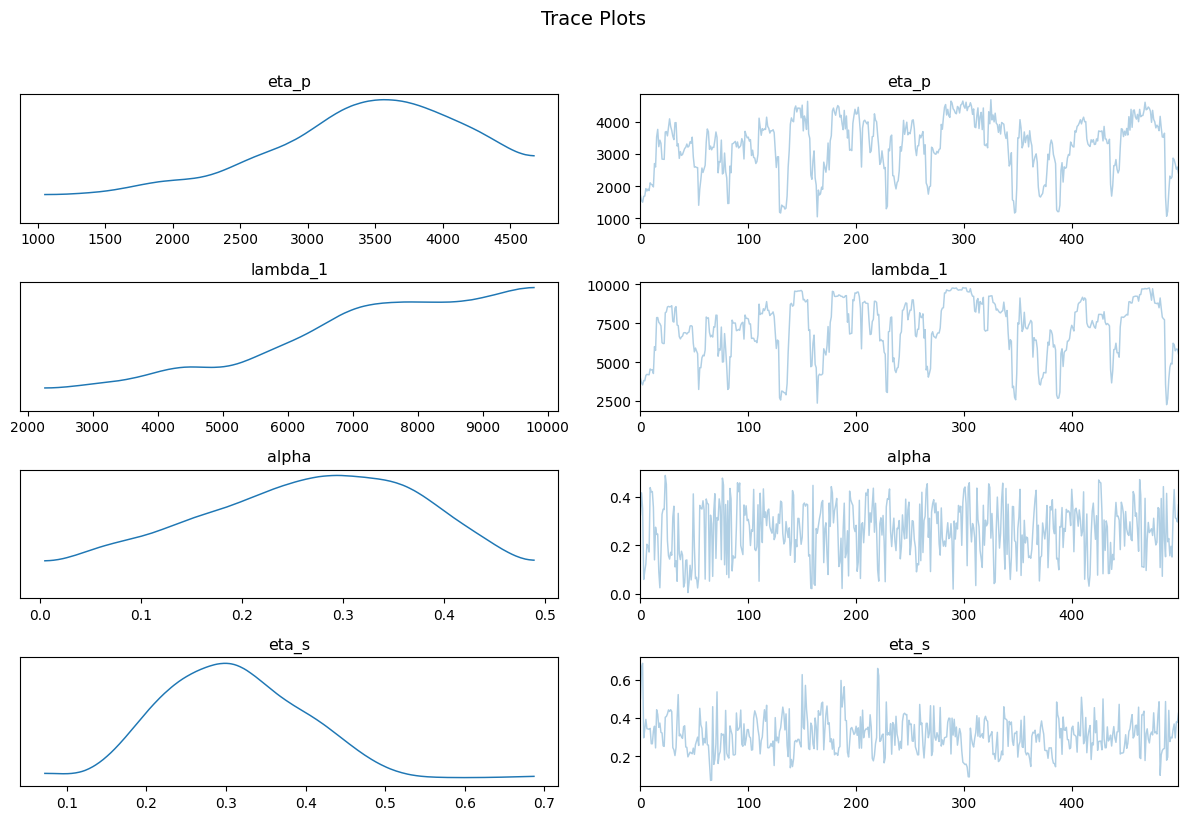

In [9]:
# ArviZ trace plots
idata = result.to_inference_data()

axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

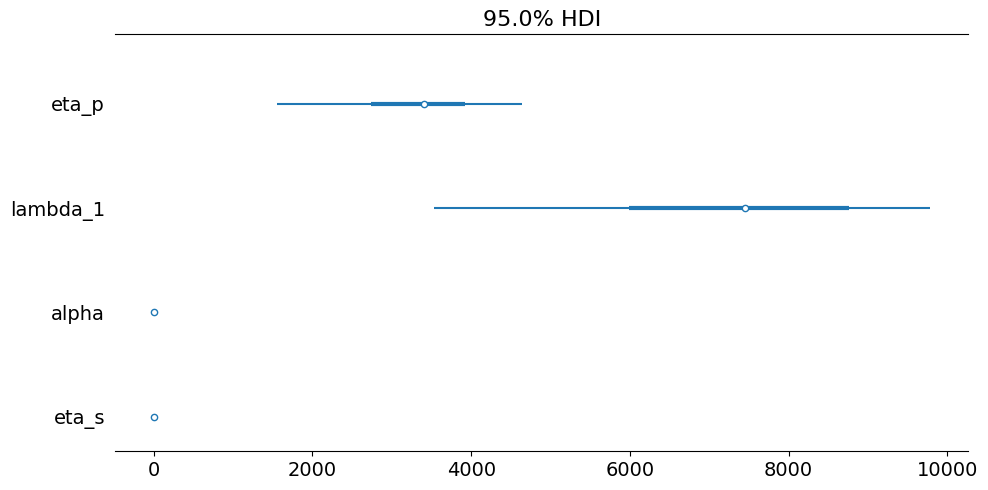

In [10]:
# Forest plot
axes = az.plot_forest(
    idata,
    var_names=param_names,
    combined=True,
    hdi_prob=0.95,
    figsize=(10, 5),
)
fig = axes.ravel()[0].figure
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Posterior Predictive Check

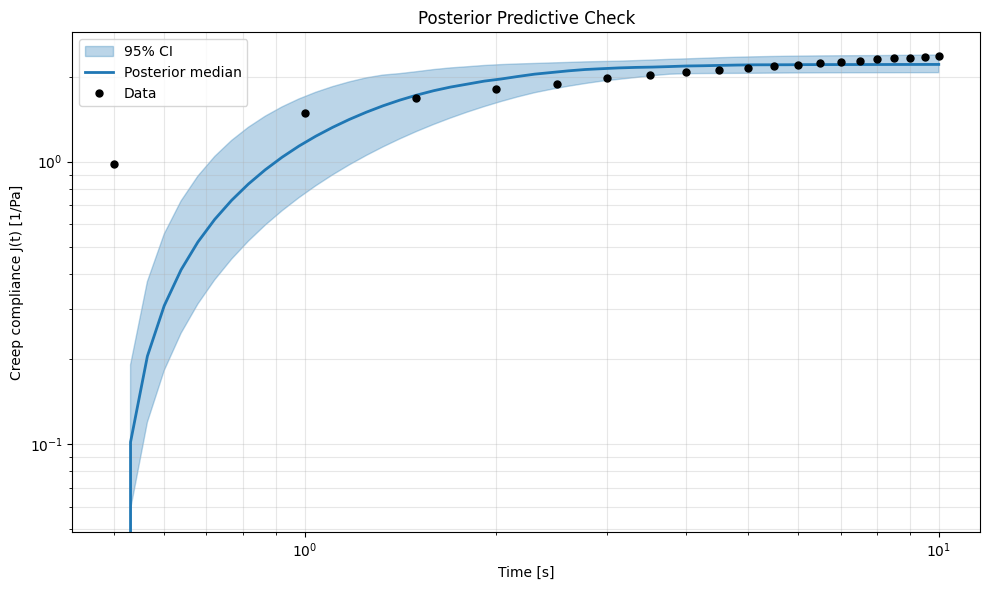

In [11]:
# Posterior predictive with 95% credible intervals
posterior = result.posterior_samples
n_draws = min(100, len(posterior["alpha"]))  # Fewer draws for ODE-based prediction

time_pred = np.logspace(
    np.log10(time_data.min()),
    np.log10(time_data.max()),
    50,  # Fewer points for ODE
)

pred_samples = []
for i in range(n_draws):
    # Set parameters from posterior
    for name in param_names:
        model.parameters.set_value(name, float(posterior[name][i]))
    
    # Predict using the correct API
    pred_i = model.predict(time_pred, test_mode="creep", sigma_applied=sigma_applied)
    pred_samples.append(np.array(pred_i))

pred_samples = np.array(pred_samples)
pred_median = np.median(pred_samples, axis=0)
pred_lo = np.percentile(pred_samples, 2.5, axis=0)
pred_hi = np.percentile(pred_samples, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(time_pred, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI")
ax.loglog(time_pred, pred_median, "-", lw=2, color="C0", label="Posterior median")
ax.loglog(time_data, J_data, "ko", markersize=5, label="Data")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Creep compliance J(t) [1/Pa]")
ax.set_title("Posterior Predictive Check")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Parameter Summary

In [12]:
# NLSQ vs Bayesian comparison
print("Parameter Comparison: NLSQ vs Bayesian")
print("=" * 70)
print(f"{'Param':>12s}  {'NLSQ':>12s}  {'Bayes median':>14s}  {'95% CI':>26s}")
print("-" * 70)

# Reset NLSQ values first
for name, val in initial_values.items():
    model.parameters.set_value(name, val)

for name in param_names:
    nlsq_val = initial_values[name]
    bayes_samples = posterior[name]
    median = float(np.median(bayes_samples))
    lo = float(np.percentile(bayes_samples, 2.5))
    hi = float(np.percentile(bayes_samples, 97.5))
    print(f"{name:>12s}  {nlsq_val:12.4g}  {median:14.4g}  [{lo:.4g}, {hi:.4g}]")

Parameter Comparison: NLSQ vs Bayesian
       Param          NLSQ    Bayes median                      95% CI
----------------------------------------------------------------------
       eta_p         14.32            3403  [1340, 4490]
    lambda_1         26.21            7456  [3044, 9727]
       alpha     5.723e-10          0.2702  [0.0433, 0.4513]
       eta_s        0.1779          0.3039  [0.1568, 0.5009]


## 8. Save Results

In [13]:
# Save results
output_dir = os.path.join("..", "outputs", "giesekus", "creep")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates
nlsq_params = initial_values.copy()
with open(os.path.join(output_dir, "nlsq_params_creep.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save posterior samples
posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_creep.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/giesekus/creep/


## Key Takeaways

1. **Creep compliance** J(t) = γ(t)/σ₀ characterizes the strain response under constant stress.

2. **Short-time behavior** (t << λ) is elastic: γ ≈ σ₀/G (instantaneous elastic strain).

3. **Long-time behavior** (t >> λ) is viscous: γ ≈ σ₀·t/η (steady flow).

4. **Giesekus vs Maxwell**: The quadratic term introduces stress-dependent nonlinearity. At high stresses, Giesekus shows faster creep than Maxwell.

5. **Biological materials** like mucus show complex viscoelastic behavior with multiple relaxation times.

### Experimental Notes

- Creep tests are sensitive to **material aging** and **thixotropy**
- Low stress creep probes **linear regime** (Giesekus ≈ Maxwell)
- High stress creep probes **nonlinear regime** (α effect visible)

### Next Steps

- **NB 06**: Stress relaxation
- **NB 07**: LAOS